In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
from pandas.plotting import parallel_coordinates
import pytz, nltk
from pytz import common_timezones, all_timezones

import scipy as sp
import scipy.stats as stats
import pylab



import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
matplotlib.style.use('seaborn-talk')
matplotlib.style.use('fivethirtyeight');


import scipy
import os
import plotly
plotly.offline.init_notebook_mode(connected=True)

# Load Training Data

In [2]:
import sqlite3

with sqlite3.connect('turbofandata.db') as connection:
    dftrain = pd.read_sql('SELECT * from dftrain', connection)

# Neural Network

Use a NN to train a classfier with a new type of target. Instead of **breakdown**, make a new binary target capturing whether it will fail withint the next TTF **time_cycles** (Time to Failure)

In [3]:
dftrain.head()

unit_nr  time_cycles  setting_1  setting_2  setting_3     s_1     s_2  \
0        1            1    -0.0007    -0.0004      100.0  518.67  641.82   
1        1            2     0.0019    -0.0003      100.0  518.67  642.15   
2        1            3    -0.0043     0.0003      100.0  518.67  642.35   
3        1            4     0.0007     0.0000      100.0  518.67  642.35   
4        1            5    -0.0019    -0.0002      100.0  518.67  642.37   

       s_3      s_4    s_5  ...    s_15  s_16  s_17  s_18   s_19   s_20  \
0  1589.70  1400.60  14.62  ...  8.4195  0.03   392  2388  100.0  39.06   
1  1591.82  1403.14  14.62  ...  8.4318  0.03   392  2388  100.0  39.00   
2  1587.99  1404.20  14.62  ...  8.4178  0.03   390  2388  100.0  38.95   
3  1582.79  1401.87  14.62  ...  8.3682  0.03   392  2388  100.0  38.88   
4  1582.85  1406.22  14.62  ...  8.4294  0.03   393  2388  100.0  38.90   

      s_21  RUL  breakdown       id  
0  23.4190  191          0  1fd_001  
1  23.4236  190          0  1fd_001  
2  23.3442  189          0  1fd_001  
3  23.3739  188          0  1fd_001  
4  23.4044  187          0  1fd_001  

[5 rows x 29 columns]

In [4]:
dftrain.columns

Index(['unit_nr', 'time_cycles', 'setting_1', 'setting_2', 'setting_3', 's_1',
       's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11',
       's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20',
       's_21', 'RUL', 'breakdown', 'id'],
      dtype='object')

In [5]:
TTF = 10 # Can change this to get more or less "lead time"; ideally want it to be as large as possible
# as large as the data supports ; as long as there are patterns in the data that the NN can leverge to
# produce a highly/eerily accurate model.

**RUL** = Remaining Useful Life

The new **label** target is 1 whenever the Remaining Useful Life is less than TTF, and 0 otherwise.

In [6]:
dftrain['label'] = np.where(dftrain['RUL'] <= TTF, 1, 0 )


In [7]:
#input_cols = ['time_cycles', 'setting_1', 'setting_2', 'setting_3', 's_1',
#       's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11',
#       's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20',
#       's_21']
input_cols = ['setting_1', 'setting_2', 'setting_3', 's_1',
       's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11',
       's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20',
       's_21']
#output_cols = ['breakdown']
output_cols = ['label']


The **breakdown** column is an indicator variable where 0 indicates the engine is operational, and 1 indicates that it has failed.

In [8]:
dftrain['breakdown'].value_counts()


0    159650
1       709
Name: breakdown, dtype: int64

In [9]:
dftrain['label'].value_counts()


0    152560
1      7799
Name: label, dtype: int64

Create an explicit **validation** set of some subset of ids in dftrain:

set the random seed to ensure reproducibility.

In [10]:
np.random.seed(2020)
ids = dftrain['id'].unique()
np.random.shuffle(ids)
len(ids)
ids[:10]

array(['26fd_004', '127fd_002', '39fd_004', '164fd_004', '10fd_002',
       '55fd_001', '77fd_001', '193fd_002', '95fd_002', '227fd_004'],
      dtype=object)

In [11]:
VAL_SIZE = 0.25
val_index = int(len(ids)*VAL_SIZE)
val_ids = ids[:val_index]
dfval = dftrain[dftrain.id.isin(val_ids)].copy()
dfval.id.nunique()

177

In [13]:
dftrain.id.nunique()

709

In [14]:
dftrain = dftrain[~dftrain.id.isin(val_ids)].copy()

In [16]:
dftrain.id.nunique()

532

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer



y = dftrain[output_cols].to_numpy()
y = np.ravel(y)
X = dftrain[input_cols].to_numpy()


In [18]:
# Install a pip package in the current Jupyter kernel
import sys
#!{sys.executable} -m pip install keras
#!{sys.executable} -m pip install tensorflow

In [19]:
# import required libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.layers import Dense , LSTM, Dropout
from keras.models import Sequential, load_model
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import math

#import xgboost
import time
from tqdm import tqdm


First break up into a training and test set, then address the class imbalance problem
on just the training set.

In [20]:


X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,
                        random_state=17,test_size=0.25)


In [21]:
pd.Series(y_train).value_counts(normalize=True)


0    0.951323
1    0.048677
dtype: float64

In [22]:
pd.Series(y_test).value_counts(normalize=True)

0    0.951324
1    0.048676
dtype: float64

In [23]:
#!{sys.executable} -m pip install imblearn

Apply the StandardScaler normalization **BEFORE** oversampling or SMOTE.

In [24]:
scaler_xtrain = StandardScaler()
scaler_xtrain.fit(X_train)
X_train_norm = scaler_xtrain.transform(X_train) 
X_test_norm = scaler_xtrain.transform(X_test)


from imblearn.over_sampling import SMOTE

USE_SMOTE = False
USE_ROS = True

if USE_SMOTE:

    from imblearn.over_sampling import SMOTE
    smote = SMOTE(sampling_strategy='minority')
    #smote = SMOTE(sampling_strategy=0.5)
    X_train_sm, y_train_sm = smote.fit_sample(X_train_norm, y_train)



if USE_ROS:
    from imblearn.over_sampling import RandomOverSampler
    ros = RandomOverSampler(random_state=0)
    X_train_sm, y_train_sm = ros.fit_sample(X_train_norm, y_train)


In [25]:
pd.Series(y_train_sm).value_counts()

1    85777
0    85777
dtype: int64

In [26]:
X_train_sm.shape, y_train_sm.shape

((171554, 24), (171554,))

* X_train_sm, y_train_sm
* X_test_norm, y_test
* scaler_xtrain

In [27]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import keras
from keras import layers
from keras.layers import Dense, Dropout
from keras.models import Sequential
import keras.regularizers as regularizers
from keras import optimizers

In [28]:
X_train_sm.shape[1:], X_train_norm.shape[1], X_train_sm.shape


((24,), 24, (171554, 24))

In [29]:
import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
import keras.regularizers as regularizers
from keras import optimizers

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy')

model = Sequential()
model.add(Dense(50, input_dim=X_train_sm.shape[1], activation='relu',
            kernel_initializer=keras.initializers.GlorotNormal()))
model.add(Dropout(0.1))
model.add(Dense(45,activation='relu',
            kernel_initializer=keras.initializers.GlorotNormal()))
model.add(Dense(45, activation='relu',
            kernel_initializer=keras.initializers.GlorotNormal()))
model.add(Dropout(0.1))
model.add(Dense(25,  activation='relu',
            kernel_initializer=keras.initializers.GlorotNormal()))
model.add(Dense(1, activation='sigmoid'))




opt_defaultparams = keras.optimizers.Adamax(learning_rate=0.001,
                             beta_1=0.9, beta_2=0.999,
                    epsilon=1e-07, name="Adamax")

opt = keras.optimizers.Adamax(learning_rate=0.0005,
                             beta_1=0.9, beta_2=0.999,
                    epsilon=1e-07, name="Adamax")



model.compile(optimizer=opt_defaultparams,
                 loss='binary_crossentropy',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                1250      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 45)                2295      
_________________________________________________________________
dense_2 (Dense)              (None, 45)                2070      
_________________________________________________________________
dropout_1 (Dropout)          (None, 45)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1150      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 2

evaluate the cell below multiple times; increasing the batch size
with each iteration.

In [30]:
#history = model.fit(X_train_sm,
#                y_train_sm, 
#        validation_data = (X_test_norm, y_test),
#    epochs = 5000,
#                shuffle=True,
#                    callbacks=[early_stopping],
#    batch_size=1024)

In [31]:
batch_sizes = [8,8,16,16,32,32,64,64,128,128,256,256,512,512,1024,1024,1024]

for b in batch_sizes:
    history = model.fit(X_train_sm,
                y_train_sm, 
        validation_data = (X_test_norm, y_test),
    epochs = 5000,
                shuffle=True,
                    callbacks=[early_stopping],
    batch_size=b)

Epoch 1/5000
21445/21445 [==============================] - 24s 1ms/step - loss: 0.3282 - accuracy: 0.8448 - val_loss: 0.1409 - val_accuracy: 0.9377
Epoch 2/5000
21445/21445 [==============================] - 24s 1ms/step - loss: 0.1340 - accuracy: 0.9518 - val_loss: 0.1796 - val_accuracy: 0.9225
Epoch 1/5000
21445/21445 [==============================] - 23s 1ms/step - loss: 0.1152 - accuracy: 0.9592 - val_loss: 0.1098 - val_accuracy: 0.9510
Epoch 2/5000
21445/21445 [==============================] - 24s 1ms/step - loss: 0.1096 - accuracy: 0.9615 - val_loss: 0.1459 - val_accuracy: 0.9374
Epoch 1/5000
10723/10723 [==============================] - 12s 1ms/step - loss: 0.1036 - accuracy: 0.9638 - val_loss: 0.1263 - val_accuracy: 0.9464
Epoch 2/5000
10723/10723 [==============================] - 12s 1ms/step - loss: 0.1021 - accuracy: 0.9641 - val_loss: 0.1455 - val_accuracy: 0.9404
Epoch 1/5000
10723/10723 [==============================] - 12s 1ms/step - loss: 0.1003 - accuracy: 0.9650

In [32]:
history = model.fit(X_train_sm,
                y_train_sm, 
        validation_data = (X_test_norm, y_test),
    epochs = 5000,
                shuffle=True,
                    callbacks=[early_stopping],
    batch_size=2028)

Epoch 1/5000
85/85 [==============================] - 0s 6ms/step - loss: 0.0819 - accuracy: 0.9723 - val_loss: 0.1051 - val_accuracy: 0.9563
Epoch 2/5000
85/85 [==============================] - 0s 5ms/step - loss: 0.0813 - accuracy: 0.9723 - val_loss: 0.0994 - val_accuracy: 0.9578
Epoch 3/5000
85/85 [==============================] - 0s 5ms/step - loss: 0.0809 - accuracy: 0.9723 - val_loss: 0.0985 - val_accuracy: 0.9589
Epoch 4/5000
85/85 [==============================] - 0s 6ms/step - loss: 0.0816 - accuracy: 0.9723 - val_loss: 0.0970 - val_accuracy: 0.9589


In [33]:
history = model.fit(X_train_sm,
                y_train_sm, 
        validation_data = (X_test_norm, y_test),
    epochs = 5000,
                shuffle=True,
                    callbacks=[early_stopping],
    batch_size=5000)

Epoch 1/5000
35/35 [==============================] - 0s 11ms/step - loss: 0.0806 - accuracy: 0.9728 - val_loss: 0.0971 - val_accuracy: 0.9585
Epoch 2/5000
35/35 [==============================] - 0s 9ms/step - loss: 0.0801 - accuracy: 0.9730 - val_loss: 0.0968 - val_accuracy: 0.9589
Epoch 3/5000
35/35 [==============================] - 0s 10ms/step - loss: 0.0804 - accuracy: 0.9727 - val_loss: 0.0991 - val_accuracy: 0.9581


In [34]:
import plotly.express as px

In [35]:
scoretrain = model.evaluate(X_train_sm, y_train_sm)
print(scoretrain)


5362/5362 [==============================] - 5s 1ms/step - loss: 0.0777 - accuracy: 0.9732: 0s - loss: 0
[0.07773355394601822, 0.9732037782669067]


In [36]:
scoretest = model.evaluate(X_test_norm, y_test)
print(scoretest)



940/940 [==============================] - 1s 1ms/step - loss: 0.0991 - accuracy: 0.9581
[0.09905203431844711, 0.9580782651901245]


In [37]:
_, train_acc = model.evaluate(X_train_sm, y_train_sm, verbose=0)
_, test_acc = model.evaluate(X_test_norm, y_test, verbose=0)


In [38]:
print(f" Train: {train_acc} , Test: {test_acc}")

 Train: 0.9732037782669067 , Test: 0.9580782651901245


In [39]:
# predict probabilities for test set
yhat_probs = model.predict(X_test_norm, verbose=0)
# predict crips classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = (model.predict(X_test_norm, verbose=0) > 0.5).astype("int32") 

In [40]:
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import recall_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# accuracy: (tp + tn ) / ( p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print(f"accuracy: {accuracy}")
# precision: tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print(f"precision: {precision}")
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print(f"Recall: {recall}")
# f1 = 2 tp / (2 tp + tp + fn)
f1 = f1_score(y_test, yhat_classes)
print(f"F1 score : {f1}")

accuracy: 0.9580782539260048
precision: 0.5381149079984979
Recall: 0.9794941900205059
F1 score : 0.6946194861851673


In [41]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [42]:
def confusion_matrix(actual, predicted):
    plt.figure(figsize=(5,5))
    sns.heatmap(sklearn.metrics.confusion_matrix(actual,predicted),annot=True,fmt='.5g')
    plt.ylabel('actual class')
    plt.xlabel('predicted class')
    plt.show()


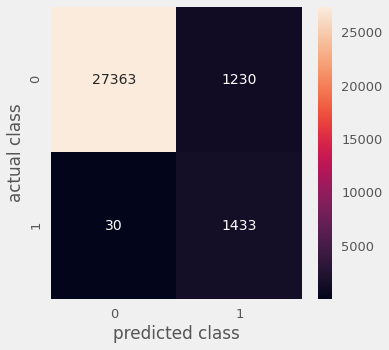

In [43]:
confusion_matrix(y_test, yhat_classes)

In [44]:
def expected_profit(y_true,y_pred):
    TP=0
    FP=0
    TN=0
    FN=0
    for i in range(len(y_true)):
        if (y_true[i] != y_pred[i]) & (y_pred[i] == 1):
            FP += 1
        elif (y_true[i] != y_pred[i]) & (y_pred[i] == 0):
            FN += 1
        elif (y_true[i] == y_pred[i]) & (y_pred[i] == 0):
            TN += 1
        else:
            TP += 1
    print(f'TP ={TP}, TN = {TN}, FP = {FP}, FN = {FN}')
    print (f'expected profit {(300 * TP - 200 * FN - 100 * FP) * 1000}')
    return 

In [45]:
expected_profit(y_test, yhat_classes)

TP =1433, TN = 27363, FP = 1230, FN = 30
expected profit 300900000


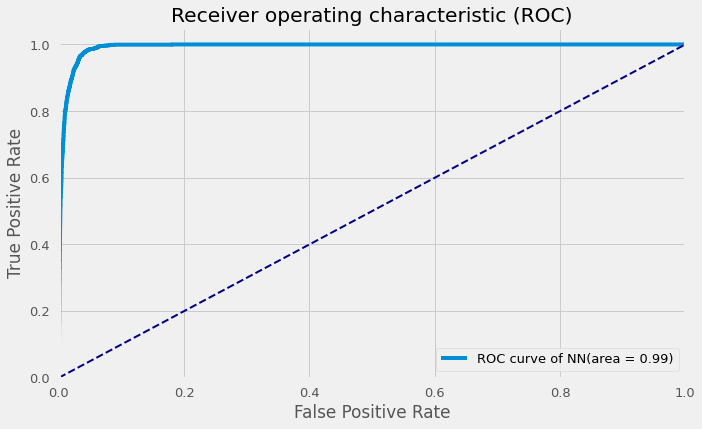

In [46]:
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(y_test,  yhat_probs)
auc_xgb = metrics.auc(fpr_xgb,  tpr_xgb)

plt.figure(figsize=(10, 6))
plt.plot(fpr_xgb,tpr_xgb, label='ROC curve of NN(area = %0.2f)' % auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_test,  yhat_classes))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     28593
           1       0.54      0.98      0.69      1463

    accuracy                           0.96     30056
   macro avg       0.77      0.97      0.84     30056
weighted avg       0.98      0.96      0.96     30056



# Evaluation metrics on the dfval dataset:

In [48]:
real_x_test = dfval[input_cols].to_numpy()
real_x_test_norm = scaler_xtrain.transform(real_x_test)

real_y_test = dfval[output_cols].to_numpy()
real_y_test = np.ravel(real_y_test)


# predict probabilities for test set
yhat_probs = model.predict(real_x_test_norm, verbose=0)
# predict crips classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = (model.predict(real_x_test_norm, verbose=0) > 0.5).astype("int32") 


# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

# accuracy: (tp + tn ) / ( p + n)
accuracy = accuracy_score(real_y_test, yhat_classes)
print(f"accuracy: {accuracy}")
# precision: tp / (tp + fp)
precision = precision_score(real_y_test, yhat_classes)
print(f"precision: {precision}")
# recall: tp / (tp + fn)
recall = recall_score(real_y_test, yhat_classes)
print(f"Recall: {recall}")
# f1 = 2 tp / (2 tp + tp + fn)
f1 = f1_score(real_y_test, yhat_classes)
print(f"F1 score : {f1}")

accuracy: 0.9610085457308718
precision: 0.555978898007034
Recall: 0.9743194658448896
F1 score : 0.7079679044597873


Cohen's kappa: 0.6887415259430809
ROC AUC: 0.9931855603177849


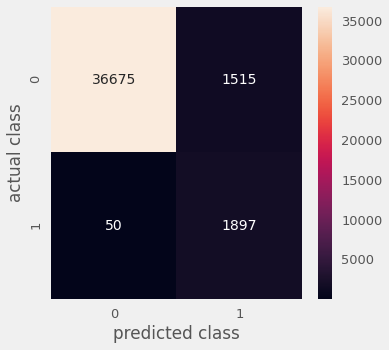

None


In [49]:
# kappa
kappa = cohen_kappa_score(real_y_test, yhat_classes)
print(f"Cohen's kappa: {kappa}")
# ROC AUC
auc = roc_auc_score(real_y_test, yhat_probs)
print(f"ROC AUC: {auc}")
# confusion matrix
conf_mat = confusion_matrix(real_y_test, yhat_classes)
print(conf_mat)

In [50]:
expected_profit(real_y_test, yhat_classes)

TP =1897, TN = 36675, FP = 1515, FN = 50
expected profit 407600000


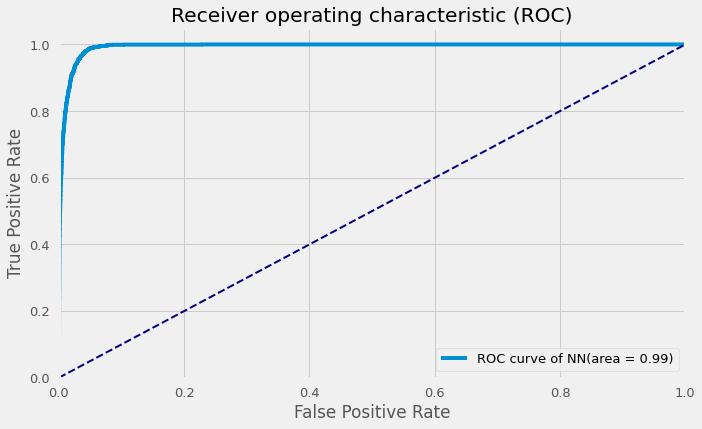

In [51]:
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(real_y_test,  yhat_probs)
auc_xgb = metrics.auc(fpr_xgb,  tpr_xgb)

plt.figure(figsize=(10, 6))
plt.plot(fpr_xgb,tpr_xgb, label='ROC curve of NN(area = %0.2f)' % auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [52]:
from sklearn.metrics import classification_report
print(classification_report(real_y_test,  yhat_classes))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     38190
           1       0.56      0.97      0.71      1947

    accuracy                           0.96     40137
   macro avg       0.78      0.97      0.84     40137
weighted avg       0.98      0.96      0.97     40137



In [53]:
from sklearn.metrics import fowlkes_mallows_score

fmi_score = fowlkes_mallows_score(real_y_test,  yhat_classes)
print(fmi_score)


0.9578509638761807


In [54]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(real_y_test, yhat_probs)
print(roc_auc)


0.9931855603177849


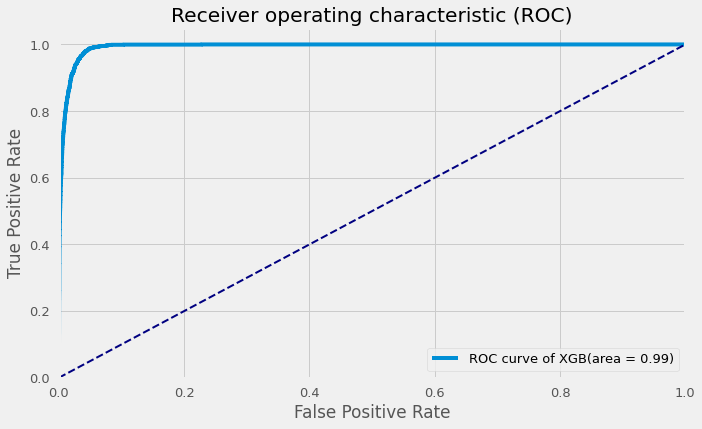

In [55]:
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(real_y_test,  yhat_probs)
auc_xgb = metrics.auc(fpr_xgb,  tpr_xgb)

plt.figure(figsize=(10, 6))
plt.plot(fpr_xgb,tpr_xgb, label='ROC curve of XGB(area = %0.2f)' % auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [56]:
yhat = model.predict(real_x_test_norm, verbose=0)

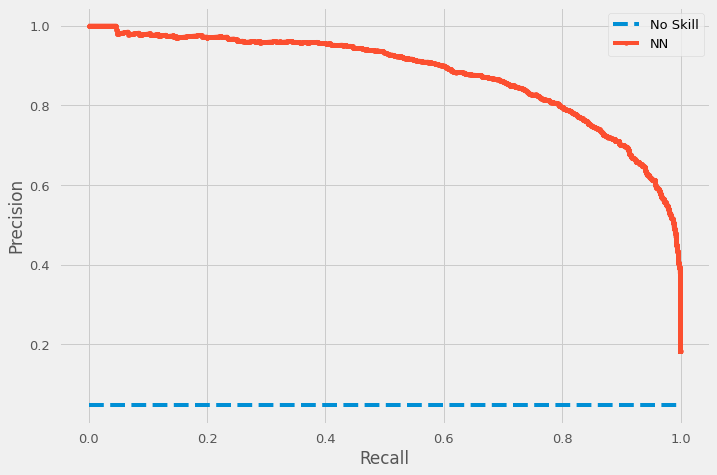

PR AUC 0.8799844216800001


In [57]:
from matplotlib import pyplot
from sklearn.metrics import auc
#yhat = clf.predict_proba(real_x_test_norm)
yhat = model.predict(real_x_test_norm, verbose=0)

pos_probs = yhat
no_skill = len(real_y_test[real_y_test==1]) / len(real_y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
precision, recall, _ = metrics.precision_recall_curve(real_y_test, pos_probs)
# plot the model precision-recall curve
auc_score = auc(recall, precision)
pyplot.plot(recall, precision, marker='.', label='NN')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
print(f"PR AUC {auc_score}")

# Save the model, the scaler object, and the dfval dataset

In [58]:
from keras.models import model_from_json
from keras.models import model_from_yaml
from pickle import load
from pickle import dump
import sqlite3

In [59]:
dump(scaler_xtrain, open('scaler_xtrain_notime.pkl', 'wb'))
model.save('model_notime.h5')



In [60]:
with sqlite3.connect('turbofandata.db') as connection:
    dfval.to_sql(
    'dfval_notime',connection,index=False,
    if_exists='replace')

In [61]:
from keras.models import load_model


In [62]:
model_new = load_model('model_notime.h5')
scaler_xtrain_new = load(open('scaler_xtrain_notime.pkl','rb'))

with sqlite3.connect('turbofandata.db') as connection:
    dfval_new = pd.read_sql('SELECT * from dfval_notime', connection)